In [ ]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F

import zipfile
from tqdm import tqdm
import numpy as np

## preps

In [ ]:
class EarlyStopping():
  def __init__(self, min_delta=0.001, tolerance=20):
    self.tolerance = tolerance
    self.min_delta = min_delta
    self.counter = 0
    self.flag = False
    self.min_loss = 1000

  def __call__(self, val_loss):
    if (val_loss - self.min_loss) > self.min_delta:
      self.counter += 1
      if self.counter >= self.tolerance:
        self.flag = True
    self.min_loss = val_loss if val_loss < self.min_loss else self.min_loss

In [ ]:
def train_one_epoch(model, train_dataloader, loss_func, optimizer, device):
  model.train()
  epoch_loss = []
  for (local_batch, local_label) in train_dataloader:
    (local_batch, local_label) = (local_batch.to(device), local_label.to(device))
    optimizer.zero_grad()
    y_pred = model.forward(local_batch)
    curr_loss = criterion.forward(y_pred, local_label)
    curr_loss.backward()
    optimizer.step()
    epoch_loss.append(curr_loss.item())
  return np.mean(epoch_loss)

#use with torch.no_grad()
def val_one_epoch(model, val_dataloader, loss_func, device):
  model.eval()
  epoch_loss = []
  for (local_batch, local_label) in val_dataloader:
    (local_batch, local_label) = (local_batch.to(device), local_label.to(device))
    y_pred = model.forward(local_batch)
    curr_loss = criterion.forward(y_pred, local_label)
    epoch_loss.append(curr_loss.item())
  return np.mean(epoch_loss)

def test_model(model, test_dataloader, device, classes):
  model.eval()
  test_hits = 0
  total = 0
  confusion_matrix = torch.zeros(len(classes), len(classes))
  for (local_batch, local_label) in test_dataloader:
    (local_batch, local_label) = (local_batch.to(device), local_label.to(device))
    y_pred = model.forward(local_batch)
    _, preds = torch.max(y_pred, 1)
    test_hits += torch.sum(preds.view(-1) == local_label.view(-1))
    total += torch.numel(preds.view(-1))
    for t, p in zip(local_label.view(-1), preds.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1
  return confusion_matrix, test_hits, total

In [ ]:
def get_class_names(path, skip_first=True):
  f = open(path, "r")
  lines = f.readlines()
  classes = []
  classes_to_idx = {}
  for idx, line in enumerate(lines):
    if skip_first:
      skip_first=False
      continue
    if line=="\n":
      break
    line = line.split(", ")
    classes.append(line[2].strip())
    classes_to_idx[line[2].strip()] = idx
  return classes, classes_to_idx

In [ ]:
def print_images(model, test_dataloader, device, classes):
  for (local_batch, local_label) in test_dataloader:
    (local_batch, local_label) = (local_batch.to(device), local_label.to(device))
    y_pred = model.forward(local_batch)
    _, preds = torch.max(y_pred, 1)
    break

  fig = plt.figure()
  for i in range(len(preds[0:20])):
    plt.subplot(5,4,i+1)
    plt.tight_layout()
    plt.imshow(local_batch[i][0].cpu(), cmap='gray', interpolation='none')
    plt.title(f"Truth: {classes[local_label[i].cpu()]}\npred: {classes[preds[i].cpu()]}")
    plt.xticks([])
    plt.yticks([])
  torch.cuda.empty_cache() if device == 'cuda' else None

In [ ]:
def visual_1st_layer(model, test_dataloader, device, img_n=5):
  for (local_batch, local_label) in test_dataloader:
    (local_batch, local_label) = (local_batch.to(device), local_label.to(device))
    break

  with torch.no_grad():
    data1_part_1l = model.forward1l(local_batch).cpu()

    plt.imshow(local_batch[img_n][0].cpu(), cmap='grey')


    nplots = data1_part_1l.shape[1]
    ncols = 10

    nrows = 2 + nplots//ncols
    #convert tensor to numpy image
    #npimg = np.array(t.numpy(), np.float32)

    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    #--------

    for i in range(data1_part_1l.shape[1]):
        count += 1
        ax1 = fig.add_subplot(nrows, ncols, count)

        ax1.imshow(data1_part_1l[img_n][i], cmap='gray')
    fig.show()
  torch.cuda.empty_cache() if device == 'cuda' else None

## 1. Классификация предметов одежды (датасет Fashion MNIST)



### 1.1 Решить задачу классификации, не используя сверточные слои.
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью.

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [ ]:
BATCH_SIZE = 200
INIT_LR = 1e-3
EPOCH = 150
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache() if device == 'cuda' else None

NameError: ignored

#### data prep

In [ ]:
transforms_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize([28, 28]),
    torchvision.transforms.ToTensor()
])
transforms_val = torchvision.transforms.Compose([
    torchvision.transforms.Resize([28, 28]),
    torchvision.transforms.ToTensor()
])

transforms_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize([28, 28]),
    torchvision.transforms.ToTensor()
])

In [ ]:
dataSet = torchvision.datasets.FashionMNIST(root=r'C:\Users\user\Desktop\dz\DL\lab4\data', train=True, download=True)
testDataSet = torchvision.datasets.FashionMNIST(root=r'C:\Users\user\Desktop\dz\DL\lab4\data', train=False, download=True, transform=transforms_test)

In [ ]:
trainSize = int(0.9*len(dataSet))
valSize = len(dataSet) - trainSize
trainDataSet, valDataSet = torch.utils.data.random_split(dataSet, [trainSize, valSize])
trainDataSet.dataset.transform = transforms_train
valDataSet.dataset.transform = transforms_val

In [ ]:
trainLoader = torch.utils.data.DataLoader(trainDataSet, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
valLoader = torch.utils.data.DataLoader(valDataSet, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
testLoader = torch.utils.data.DataLoader(testDataSet, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers = 0)

#### model

In [ ]:
class Model(nn.Module):
    def __init__(self, numClasses, imgShape):
        from functools import reduce
        self.n_features = reduce(lambda x, y: x*y, imgShape)
        super(Model, self).__init__()

        self.fc1 = nn.Linear(in_features=self.n_features, out_features=self.n_features*2)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.25)

        self.fc2 = nn.Linear(in_features=self.n_features*2, out_features=self.n_features*4)
        self.act2 = nn.ReLU()
        self.drop2 = nn.Dropout(0.25)

        self.fc3 = nn.Linear(in_features=self.n_features*4, out_features=self.n_features*2)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.25)

        self.fc4 = nn.Linear(in_features=self.n_features*2, out_features=numClasses)
        self.act4 = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = self.act1(x)
        x = self.drop1(x)

        x = self.fc2(x)
        x = self.act2(x)
        x = self.drop2(x)

        x = self.fc3(x)
        x = self.act3(x)
        x = self.drop3(x)

        x = self.fc4(x)
        x = self.act4(x)

        return x

#### train and stuff

In [ ]:
imgShape = dataSet[0][0].size()
model = Model(len(dataSet.classes), imgShape).to(device)
print(f'кол-во параметров в модели = {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

кол-во параметров в модели = 11085770


In [ ]:
next(model.parameters()).is_cuda

True

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=INIT_LR,
)
early_stopping = EarlyStopping(min_delta=0.01, tolerance=10)

In [ ]:
train_loss = []
val_loss = []
for epoch in tqdm(range(EPOCH)):
  epoch_train_loss = train_one_epoch(model, trainLoader, criterion, optimizer, device)
  train_loss.append(epoch_train_loss)

  with torch.no_grad():
    epoch_val_loss = val_one_epoch(model, valLoader, criterion, device)
    val_loss.append(epoch_val_loss)

  early_stopping(epoch_val_loss)
  if early_stopping.flag:
    print(f'early stop at epoch №{epoch}')
    break
torch.cuda.empty_cache() if device == 'cuda' else None

 16%|████████████▉                                                                    | 24/150 [02:57<15:34,  7.42s/it]

early stop at epoch №24


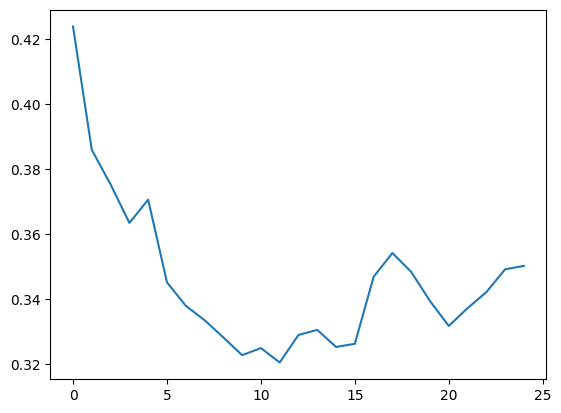

In [ ]:
df = pd.DataFrame({'val_loss': [np.mean(x) for x in val_loss], 'train_loss': [np.mean(x) for x in train_loss]})
df.plot(kind='line')

In [ ]:
with torch.no_grad():
    test_data = test_model(model, testLoader, device, dataSet.classes)
torch.cuda.empty_cache() if device == 'cuda' else None

In [ ]:
overall_accuracy = test_data[1].item()/test_data[2]
print(f'overall acc = {round(overall_accuracy*100,2)}%')

overall acc = 88.07%


<Axes: >

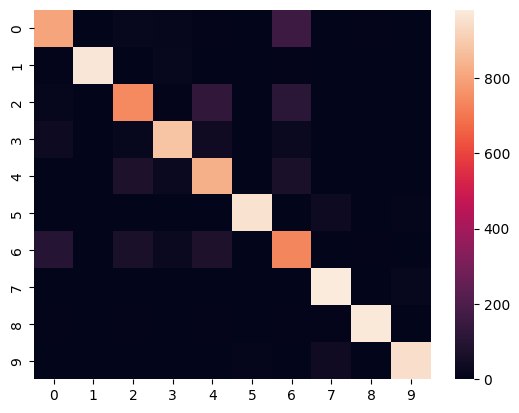

In [ ]:
from seaborn import heatmap
heatmap(test_data[0])

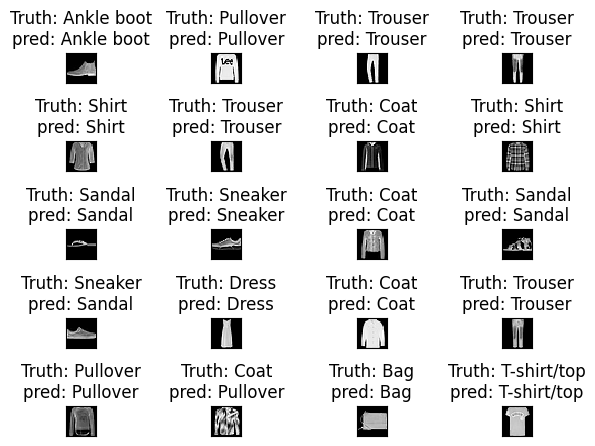

In [ ]:
print_images(model, testLoader, device, dataSet.classes)
torch.cuda.empty_cache() if device == 'cuda' else None

In [ ]:
torch.save(model.state_dict(), r'C:\Users\user\Desktop\dz\DL\lab4\results\model1_1.pth')
torch.save(optimizer.state_dict(), r'C:\Users\user\Desktop\dz\DL\lab4\results\optimizer1_1.pth')

### 1.2 Решить задачу 1.1, используя сверточную нейронную сеть.
* Добиться значения accuracy на тестовом множестве не менее 90%
* Визуализировать результаты работы первого сверточного слоя

In [ ]:
BATCH_SIZE = 256
INIT_LR = 1e-3
EPOCH = 150
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache() if device == 'cuda' else None

#### data prep

In [ ]:
transforms_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize([28, 28]),
    torchvision.transforms.ToTensor()
])
transforms_val = torchvision.transforms.Compose([
    torchvision.transforms.Resize([28, 28]),
    torchvision.transforms.ToTensor()
])

transforms_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize([28, 28]),
    torchvision.transforms.ToTensor()
])

In [ ]:
dataSet = torchvision.datasets.FashionMNIST(root=r'C:\Users\user\Desktop\dz\DL\lab4\data', train=True, download=True)
testDataSet = torchvision.datasets.FashionMNIST(root=r'C:\Users\user\Desktop\dz\DL\lab4\data', train=False, download=True, transform=transforms_test)

In [ ]:
trainSize = int(0.9*len(dataSet))
valSize = len(dataSet) - trainSize
trainDataSet, valDataSet = torch.utils.data.random_split(dataSet, [trainSize, valSize])
trainDataSet.dataset.transform = transforms_train
valDataSet.dataset.transform = transforms_val

In [ ]:
trainLoader = torch.utils.data.DataLoader(trainDataSet, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
valLoader = torch.utils.data.DataLoader(valDataSet, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
testLoader = torch.utils.data.DataLoader(testDataSet, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers = 0)

#### model

In [ ]:
class Model(nn.Module):
    def __init__(self, numClasses, imgShape):
        from functools import reduce
        super(Model, self).__init__()
        def __find_new_dim_size(dim_sizes, kernel_sizes, stride_sizes, padding_sizes, dilation_sizes):
            return (int(((dim_sizes[0] + 2*padding_sizes[0] - dilation_sizes[0]*(kernel_sizes[0] - 1) - 1)/stride_sizes[0]) + 1),
                    int(((dim_sizes[1] + 2*padding_sizes[1] - dilation_sizes[1]*(kernel_sizes[1] - 1) - 1)/stride_sizes[1]) + 1))

        self.imgShape = imgShape #[ch, h, w]
        self.conv1 = nn.Conv2d(in_channels=imgShape[0], out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(0,0), dilation=(1,1))
        cur_size = __find_new_dim_size(imgShape[1:3], (3, 3), (1, 1), (0, 0), (1, 1))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=(1,1))
        cur_size = __find_new_dim_size(cur_size, (2, 2), (2, 2), (0, 0), (1, 1))

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(0,0), dilation=(1,1))
        cur_size = __find_new_dim_size(cur_size, (3, 3), (1, 1), (0, 0), (1, 1))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=(1,1))
        cur_size = __find_new_dim_size(cur_size, (2, 2), (2, 2), (0, 0), (1, 1))

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(0,0), dilation=(1,1))
        cur_size = __find_new_dim_size(cur_size, (3, 3), (1, 1), (0, 0), (1, 1))
        self.relu3_1 = nn.ReLU()

        n_features = 128 * reduce(lambda x, y: x*y, cur_size)
        self.fc1 = nn.Linear(in_features=n_features, out_features=1024)
        self.relu3 = nn.ReLU()

        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.relu4 = nn.ReLU()

        self.fc3 = nn.Linear(in_features=512, out_features=numClasses)
        self.logSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3_1(x)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = self.relu3(x)

        x = self.fc2(x)
        x = self.relu4(x)

        x = self.fc3(x)
        out = self.logSoftmax(x)

        return out

    def forward1l(self, x):
        x = self.relu1(self.conv1(x))
        return x

#### train and stuff

In [ ]:
imgShape = dataSet[0][0].size()
model = Model(len(dataSet.classes), imgShape).to(device)
print(f'кол-во параметров в модели = {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

кол-во параметров в модели = 1803274


In [ ]:
next(model.parameters()).is_cuda

True

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=INIT_LR,
)
early_stopping = EarlyStopping(min_delta=0.01, tolerance=10)

In [ ]:
train_loss = []
val_loss = []
test_acc = []
for epoch in tqdm(range(EPOCH)):
  epoch_train_loss = train_one_epoch(model, trainLoader, criterion, optimizer, device)
  train_loss.append(epoch_train_loss)

  with torch.no_grad():
    epoch_val_loss = val_one_epoch(model, valLoader, criterion, device)
    val_loss.append(epoch_val_loss)

  early_stopping(epoch_val_loss)
  if early_stopping.flag:
    print(f'\nearly stop at epoch №{epoch}')
    break
torch.cuda.empty_cache() if device == 'cuda' else None


 13%|██████████▎                                                                      | 19/150 [02:19<17:41,  8.11s/it]


early stop at epoch №19


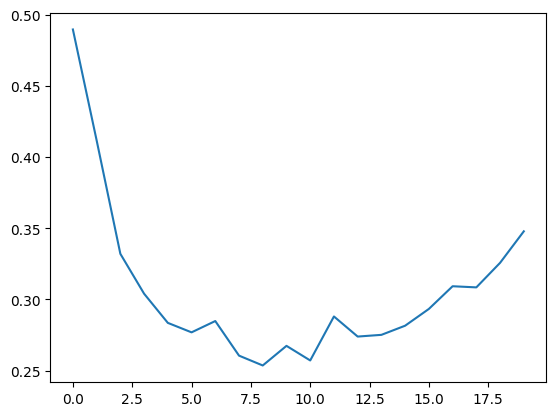

In [ ]:
df = pd.DataFrame({'val_loss': [np.mean(x) for x in val_loss], 'train_loss': [np.mean(x) for x in train_loss]})
df.plot(kind='line')

In [ ]:
with torch.no_grad():
    test_data = test_model(model, testLoader, device, dataSet.classes)
torch.cuda.empty_cache() if device == 'cuda' else None

In [ ]:
overall_accuracy = test_data[1].item()/test_data[2]
print(f'overall acc = {round(overall_accuracy*100,2)}%')

overall acc = 90.73%


<Axes: >

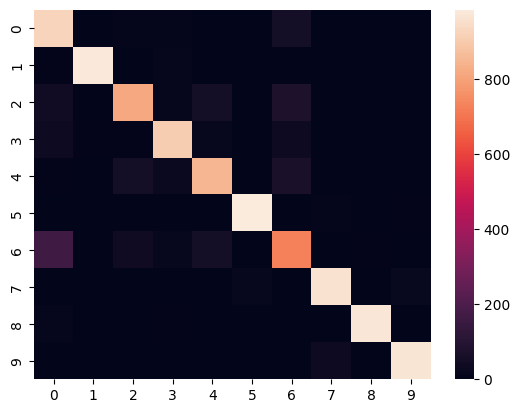

In [ ]:
from seaborn import heatmap
heatmap(test_data[0])

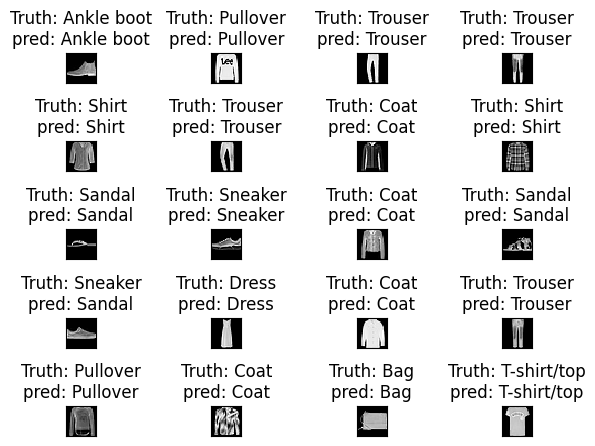

In [ ]:
print_images(model, testLoader, device, dataSet.classes)

C:\Users\user\AppData\Local\Temp\ipykernel_24212\3599481032.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


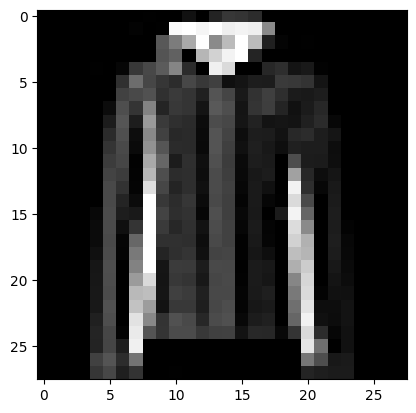

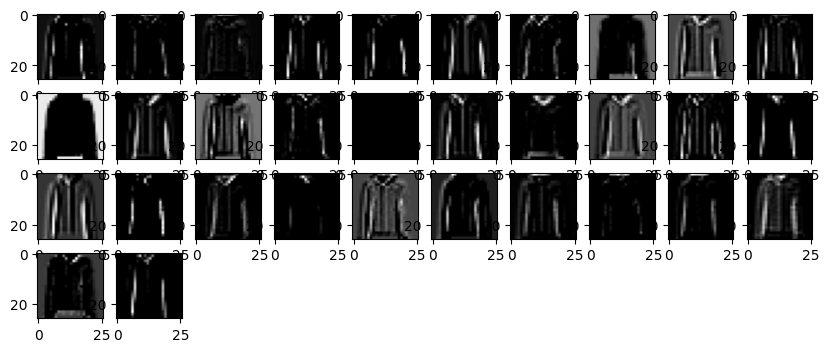

In [ ]:
visual_1st_layer(model, testLoader, device, img_n=6)

In [ ]:
torch.save(model.state_dict(), r'C:\Users\user\Desktop\dz\DL\lab4\results\model1_2.pth')
torch.save(optimizer.state_dict(), r'C:\Users\user\Desktop\dz\DL\lab4\results\optimizer1_2.pth')

##  2. Классификация изображений (датасет CIFAR 10)


### 2.1 Решить задачу классификации, не используя сверточные слои.

* Нормализовать данные (если необходимо)
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью.

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [ ]:
BATCH_SIZE = 256
INIT_LR = 1e-3
EPOCH = 150
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache() if device == 'cuda' else None

#### data prep

In [ ]:
transforms_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize([32, 32]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261])
])
transforms_val = torchvision.transforms.Compose([
    torchvision.transforms.Resize([32, 32]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261])
])

transforms_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize([32, 32]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261])
])

In [ ]:
dataSet = torchvision.datasets.CIFAR10(root=r'C:\Users\user\Desktop\dz\DL\lab4\data', train=True, download=True)
testDataSet = torchvision.datasets.CIFAR10(root=r'C:\Users\user\Desktop\dz\DL\lab4\data', train=False, download=True, transform=transforms_test)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
trainSize = int(0.9*len(dataSet))
valSize = len(dataSet) - trainSize
trainDataSet, valDataSet = torch.utils.data.random_split(dataSet, [trainSize, valSize])
trainDataSet.dataset.transform = transforms_train
valDataSet.dataset.transform = transforms_val

In [ ]:
trainLoader = torch.utils.data.DataLoader(trainDataSet, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
valLoader = torch.utils.data.DataLoader(valDataSet, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
testLoader = torch.utils.data.DataLoader(testDataSet, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers = 0)

#### model


In [ ]:
class Model(nn.Module):
    def __init__(self, numClasses, imgShape):
        from functools import reduce
        self.imgShape = imgShape #[ch, h, w]
        self.n_features = reduce(lambda x, y: x*y, imgShape)
        super(Model, self).__init__()

        self.fc1 = nn.Linear(in_features=self.n_features, out_features=self.n_features*2)
        self.relu1 = nn.ReLU()

        self.fc2 = nn.Linear(in_features=self.n_features*2, out_features=self.n_features*4)
        self.relu2 = nn.ReLU()

        self.fc4 = nn.Linear(in_features=self.n_features*4, out_features=numClasses)
        self.logSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = self.relu1(x)

        x = self.fc2(x)
        x = self.relu2(x)

        x = self.fc4(x)
        out = self.logSoftmax(x)

        return out

#### train and stuff

In [ ]:
imgShape = dataSet[0][0].size()
model = Model(len(dataSet.classes), imgShape).to(device)
print(f'кол-во параметров в модели = {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

кол-во параметров в модели = 94513162


In [ ]:
next(model.parameters()).is_cuda

True

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=INIT_LR,
)
early_stopping = EarlyStopping(min_delta=0.01, tolerance=10)

In [ ]:
train_loss = []
val_loss = []
for epoch in tqdm(range(EPOCH)):
  epoch_train_loss = train_one_epoch(model, trainLoader, criterion, optimizer, device)
  train_loss.append(epoch_train_loss)

  with torch.no_grad():
    epoch_val_loss = val_one_epoch(model, valLoader, criterion, device)
    val_loss.append(epoch_val_loss)

  early_stopping(epoch_val_loss)
  if early_stopping.flag:
    print(f'\nearly stop at epoch №{epoch}')
    break

torch.cuda.empty_cache() if device == 'cuda' else None



  0%|                                                                                          | 0/150 [00:00<?, ?it/s]

  1%|▌                                                                                 | 1/150 [00:13<32:23, 13.04s/it]

  1%|█                                                                                 | 2/150 [00:25<32:05, 13.01s/it]

  2%|█▋                                                                                | 3/150 [00:38<31:42, 12.94s/it]

  3%|██▏                                                                               | 4/150 [00:51<31:19, 12.87s/it]

  3%|██▋                                                                               | 5/150 [01:04<30:52, 12.78s/it]

  4%|███▎                                                                              | 6/150 [01:16<30:40, 12.78s/it]

  5%|███▊                                                                              | 7/150 [01:29<30:29, 12.80s/it]

  5%|████▎                    


early stop at epoch №14


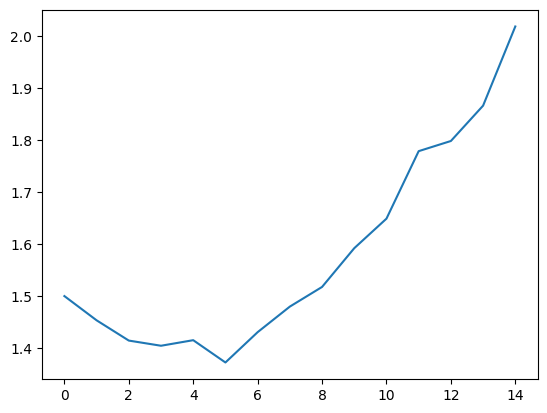

In [ ]:
df = pd.DataFrame({'val_loss': [np.mean(x) for x in val_loss], 'train_loss': [np.mean(x) for x in train_loss]})
df.plot(kind='line')

In [ ]:
with torch.no_grad():
    test_data = test_model(model, testLoader, device, dataSet.classes)
torch.cuda.empty_cache() if device == 'cuda' else None

In [ ]:
overall_accuracy = test_data[1].item()/test_data[2]
print(f'overall acc = {round(overall_accuracy*100,2)}%')

overall acc = 53.15%


<Axes: >

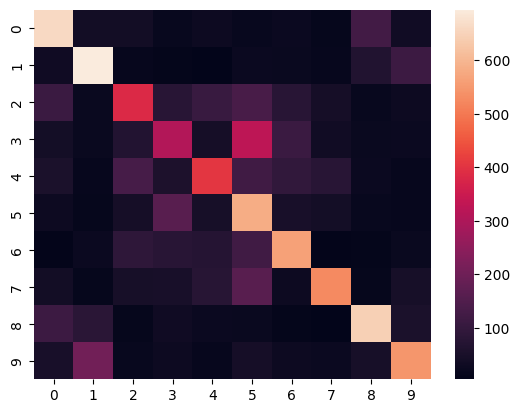

In [ ]:
from seaborn import heatmap
heatmap(test_data[0])

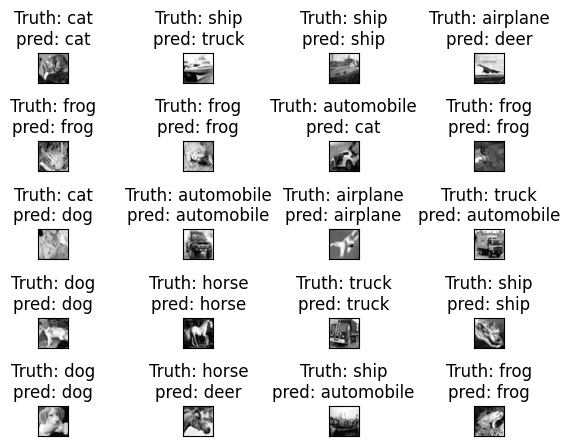

In [ ]:
print_images(model, testLoader, device, dataSet.classes)
torch.cuda.empty_cache() if device == 'cuda' else None

In [ ]:
torch.save(model.state_dict(), r'C:\Users\user\Desktop\dz\DL\lab4\results\model2_1.pth')
torch.save(optimizer.state_dict(), r'C:\Users\user\Desktop\dz\DL\lab4\results\optimizer2_1.pth')

### 2.2 Решить задачу 2.1, используя сверточную нейронную сеть.
* Добиться значения accuracy на тестовом множестве не менее 70%.
* Визуализировать результаты работы первого сверточного слоя

In [ ]:
BATCH_SIZE = 256
INIT_LR = 1e-3
EPOCH = 150
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache() if device == 'cuda' else None

#### data prep

In [ ]:
transforms_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize([32, 32]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261])
])
transforms_val = torchvision.transforms.Compose([
    torchvision.transforms.Resize([32, 32]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261])
])

transforms_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize([32, 32]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261])
])

In [ ]:
dataSet = torchvision.datasets.CIFAR10(root=r'C:\Users\user\Desktop\dz\DL\lab4\data', train=True, download=True)
testDataSet = torchvision.datasets.CIFAR10(root=r'C:\Users\user\Desktop\dz\DL\lab4\data', train=False, download=True, transform=transforms_test)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
trainSize = int(0.9*len(dataSet))
valSize = len(dataSet) - trainSize
trainDataSet, valDataSet = torch.utils.data.random_split(dataSet, [trainSize, valSize])
trainDataSet.dataset.transform = transforms_train
valDataSet.dataset.transform = transforms_val

In [ ]:
trainLoader = torch.utils.data.DataLoader(trainDataSet, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
valLoader = torch.utils.data.DataLoader(valDataSet, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
testLoader = torch.utils.data.DataLoader(testDataSet, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers = 0)

#### model


In [ ]:
class Model(nn.Module):
    def __init__(self, numClasses, imgShape):
        from functools import reduce
        super(Model, self).__init__()
        def __find_new_dim_size(dim_sizes, kernel_sizes, stride_sizes, padding_sizes, dilation_sizes):
            return (int(((dim_sizes[0] + 2*padding_sizes[0] - dilation_sizes[0]*(kernel_sizes[0] - 1) - 1)/stride_sizes[0]) + 1),
                    int(((dim_sizes[1] + 2*padding_sizes[1] - dilation_sizes[1]*(kernel_sizes[1] - 1) - 1)/stride_sizes[1]) + 1))

        self.imgShape = imgShape #[ch, h, w]

        self.conv1 = nn.Conv2d(in_channels=imgShape[0], out_channels=32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), dilation=(1,1))
        cur_size = __find_new_dim_size(imgShape[1:3], (5, 5), (1, 1), (2, 2), (1, 1))
        self.conv1_bn = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=(1,1))
        cur_size = __find_new_dim_size(cur_size, (2, 2), (2, 2), (0, 0), (1, 1))

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), dilation=(1,1))
        cur_size = __find_new_dim_size(cur_size, (5, 5), (1, 1), (2, 2), (1, 1))
        self.conv2_bn = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=(1,1))
        cur_size = __find_new_dim_size(cur_size, (2, 2), (2, 2), (0, 0), (1, 1))


        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), dilation=(1,1))
        cur_size = __find_new_dim_size(cur_size, (5, 5), (1, 1), (2, 2), (1, 1))
        self.conv3_bn = nn.BatchNorm2d(128)
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=(1,1))
        cur_size = __find_new_dim_size(cur_size, (2, 2), (2, 2), (0, 0), (1, 1))


        n_features = 128 * reduce(lambda x, y: x*y, cur_size)
        #hid 1
        self.fc1 = nn.Linear(in_features=n_features, out_features=1000)
        self.relu1 = nn.ReLU()
        #hid 2
        self.fc2 = nn.Linear(in_features=1000, out_features=1000)
        self.relu2 = nn.ReLU()
        #hid 3
        self.fc3 = nn.Linear(in_features=1000, out_features=1000)
        self.relu3 = nn.ReLU()
        #final
        self.fc4 = nn.Linear(in_features=1000, out_features=numClasses)
        self.logSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv1_bn(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.conv2_bn(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.conv3_bn(x)
        x = self.maxpool3(x)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = self.relu1(x)

        x = self.fc2(x)
        x = self.relu2(x)

        x = self.fc3(x)
        x = self.relu3(x)

        x = self.fc4(x)
        out = self.logSoftmax(x)

        return out

    def forward1l(self, x):
        x =  self.conv1_bn(self.conv1(x))
        return x

#### train and stuff

In [ ]:
imgShape = dataSet[0][0].size()
model = Model(len(dataSet.classes), imgShape).to(device)
print(f'кол-во параметров в модели = {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

кол-во параметров в модели = 4320082


In [ ]:
next(model.parameters()).is_cuda

True

In [ ]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=INIT_LR,
)
early_stopping = EarlyStopping(min_delta=0.01, tolerance=10)

In [ ]:
train_loss = []
val_loss = []
test_acc = []
for epoch in tqdm(range(EPOCH)):
  epoch_train_loss = train_one_epoch(model, trainLoader, criterion, optimizer, device)
  train_loss.append(epoch_train_loss)

  with torch.no_grad():
    epoch_val_loss = val_one_epoch(model, valLoader, criterion, device)
    val_loss.append(epoch_val_loss)

  early_stopping(epoch_val_loss)
  if early_stopping.flag:
    print(f'\nearly stop at epoch №{epoch}')
    break

torch.cuda.empty_cache() if device == 'cuda' else None




  0%|                                                                                          | 0/150 [00:00<?, ?it/s]


  1%|▌                                                                                 | 1/150 [00:11<28:08, 11.33s/it]


  1%|█                                                                                 | 2/150 [00:22<27:50, 11.29s/it]


  2%|█▋                                                                                | 3/150 [00:33<27:43, 11.32s/it]


  3%|██▏                                                                               | 4/150 [00:44<27:15, 11.20s/it]


  3%|██▋                                                                               | 5/150 [00:55<26:59, 11.17s/it]


  4%|███▎                                                                              | 6/150 [01:07<26:44, 11.14s/it]


  5%|███▊                                                                              | 7/150 [01:18<26:28, 11.11s/it]


  5%|████▎           


early stop at epoch №14


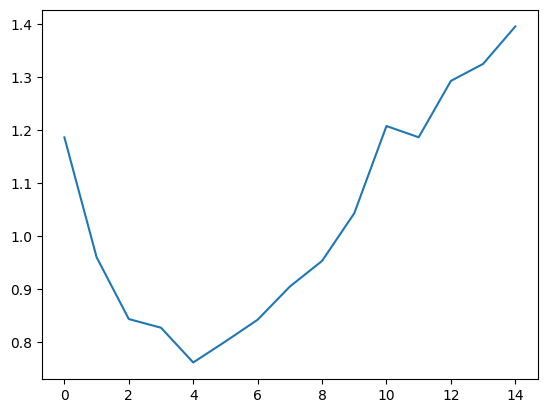

In [ ]:
df = pd.DataFrame({'val_loss': [np.mean(x) for x in val_loss], 'train_loss': [np.mean(x) for x in train_loss]})
df.plot(kind='line')

In [ ]:
with torch.no_grad():
    test_data = test_model(model, testLoader, device, dataSet.classes)
torch.cuda.empty_cache() if device == 'cuda' else None

In [ ]:
overall_accuracy = test_data[1].item()/test_data[2]
print(f'overall acc = {round(overall_accuracy*100,2)}%')

overall acc = 75.05%


<Axes: >

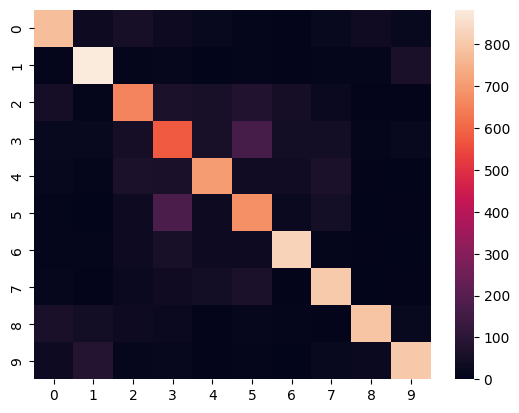

In [ ]:
from seaborn import heatmap
heatmap(test_data[0])

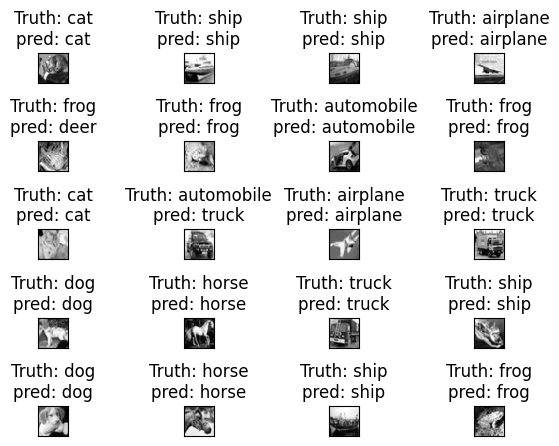

In [ ]:
print_images(model, testLoader, device, dataSet.classes)

C:\Users\user\AppData\Local\Temp\ipykernel_24212\3599481032.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


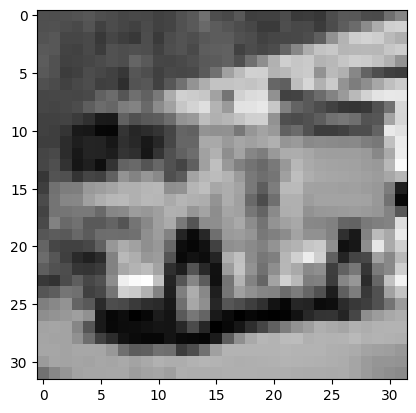

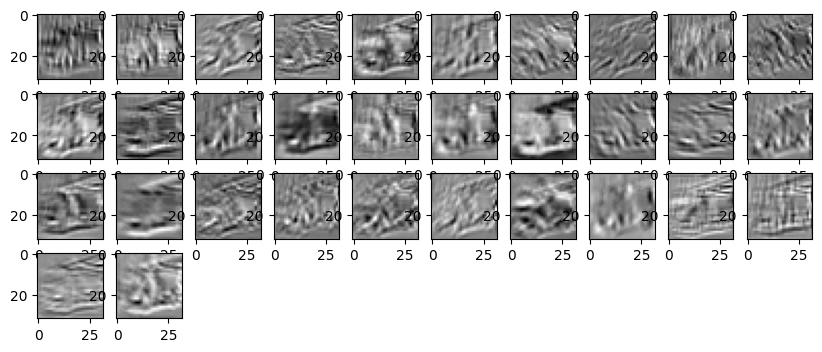

In [ ]:
visual_1st_layer(model, testLoader, device, img_n=23)

In [ ]:
torch.save(model.state_dict(), r'C:\Users\user\Desktop\dz\DL\lab4\results\model2_2.pth')
torch.save(optimizer.state_dict(), r'C:\Users\user\Desktop\dz\DL\lab4\results\optimizer2_2.pth')

## 3. Загрузка изображений из внешних источников

### 3.1 Решить задачу классификации обезьян (датасет [monkey.zip](https://disk.yandex.ru/d/OxYgY4S7aR6ulQ)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью.

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 60%

In [ ]:
BATCH_SIZE = 150
INIT_LR = 1e-3
EPOCH = 400
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache() if device == 'cuda' else None

#### data prep

In [ ]:
transforms_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize([224, 224]),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20),
    torchvision.transforms.RandomPerspective(distortion_scale=0.3, p=1.0),
    torchvision.transforms.ElasticTransform(),
    torchvision.transforms.RandomAdjustSharpness(sharpness_factor=3),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])
transforms_val = torchvision.transforms.Compose([
    torchvision.transforms.Resize([224, 224]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

transforms_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize([224, 224]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [ ]:
trainPath = r'C:\Users\user\Desktop\dz\DL\lab4\data\monkeys\training\training'
testPath = r'C:\Users\user\Desktop\dz\DL\lab4\data\monkeys\validation\validation'
labelPath = r'C:\Users\user\Desktop\dz\DL\lab4\data\monkeys\monkey_labels.txt'
dataSet = torchvision.datasets.ImageFolder(root = trainPath)
testDataSet = torchvision.datasets.ImageFolder(root = testPath, transform=transforms_test)

In [ ]:
dataSet.classes, dataSet.class_to_idx = get_class_names(labelPath)
testDataSet.classes, testDataSet.class_to_idx = get_class_names(labelPath)

In [ ]:
trainSize = int(0.9*len(dataSet))
valSize = len(dataSet) - trainSize
trainDataSet, valDataSet = torch.utils.data.random_split(dataSet, [trainSize, valSize])
trainDataSet.dataset.transform = transforms_train
valDataSet.dataset.transform = transforms_val

In [ ]:
trainLoader = torch.utils.data.DataLoader(trainDataSet, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
valLoader = torch.utils.data.DataLoader(valDataSet, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
testLoader = torch.utils.data.DataLoader(testDataSet, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers = 0)

#### model


In [ ]:
class Model(nn.Module):
    def __init__(self, numClasses, imgShape):
        from functools import reduce
        super(Model, self).__init__()
        def find_new_shape(imgShape, kernel_sizes, stride_sizes, padding_sizes, dilation_sizes, ch_out=None):
            if ch_out:
                imgShape[0] = ch_out
            imgShape[1] = int(((imgShape[1] + 2*padding_sizes[0] - dilation_sizes[0]*(kernel_sizes[0]-1) - 1)/stride_sizes[0])+1)
            imgShape[2] = int(((imgShape[2] + 2*padding_sizes[1] - dilation_sizes[1]*(kernel_sizes[1]-1) - 1)/stride_sizes[1])+1)
            return imgShape
        imgShape = list(imgShape)
        # imgShape [ch, h, w]

        self.conv1 = nn.Conv2d(in_channels=imgShape[0], out_channels=32, kernel_size=(5, 5), stride=(1, 1), padding=(0, 0), dilation=(1,1))
        imgShape = find_new_shape(imgShape, (5, 5), (1, 1), (0, 0), (1, 1), 32)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=(1,1))
        self.drop1 = nn.Dropout2d(0.25)
        imgShape = find_new_shape(imgShape, (2, 2), (2, 2), (0, 0), (1, 1))

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), dilation=(1,1))
        imgShape = find_new_shape(imgShape, (3, 3), (1, 1), (0, 0), (1, 1), 64)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=(1,1))
        self.drop2 = nn.Dropout2d(0.25)
        imgShape = find_new_shape(imgShape, (2, 2), (2, 2), (0, 0), (1, 1))

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), dilation=(1,1))
        imgShape = find_new_shape(imgShape, (3, 3), (1, 1), (0, 0), (1, 1), 128)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=(1,1))
        self.drop3 = nn.Dropout2d(0.25)
        imgShape = find_new_shape(imgShape, (2, 2), (2, 2), (0, 0), (1, 1))

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), dilation=(1,1))
        imgShape = find_new_shape(imgShape, (3, 3), (1, 1), (0, 0), (1, 1), 256)
        self.conv4_bn = nn.BatchNorm2d(256)
        self.maxpool4 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=(1,1))
        self.drop4 = nn.Dropout2d(0.25)
        imgShape = find_new_shape(imgShape, (2, 2), (2, 2), (0, 0), (1, 1))



        n_features = reduce(lambda x,y: x*y, imgShape)
        #hid 1
        self.fc1 = nn.Linear(in_features=n_features, out_features=512)
        self.lin_bn1 = nn.BatchNorm1d(512)
        self.relu1 = nn.ReLU()
        self.drop6 = nn.Dropout(0.5)
        #final
        self.fc4 = nn.Linear(in_features=512, out_features=numClasses)
        self.lin_bn4 = nn.BatchNorm1d(numClasses)
        self.logSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.drop1(self.maxpool1(self.conv1_bn(self.conv1(x))))

        x = self.drop2(self.maxpool2(self.conv2_bn(self.conv2(x))))

        x = self.drop3(self.maxpool3(self.conv3_bn(self.conv3(x))))

        x = self.drop4(self.maxpool4(self.conv4_bn(self.conv4(x))))

        x = torch.flatten(x, 1)

        x = self.drop6(self.relu1(self.lin_bn1(self.fc1(x))))

        x = self.lin_bn4(self.fc4(x))
        out = self.logSoftmax(x)

        return out

    def forward1l(self, x):
        x =  self.conv1_bn(self.conv1(x))
        return x

#### train and stuff

In [ ]:
imgShape = dataSet[0][0].size()
model = Model(len(dataSet.classes), imgShape).to(device)
print(f'кол-во параметров в модели = {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

кол-во параметров в модели = 19271966


In [ ]:
next(model.parameters()).is_cuda

True

In [ ]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=INIT_LR,
)
early_stopping = EarlyStopping(min_delta=0.1, tolerance=40)

In [ ]:
train_loss = []
val_loss = []
for epoch in tqdm(range(EPOCH)):
  epoch_train_loss = train_one_epoch(model, trainLoader, criterion, optimizer, device)
  train_loss.append(epoch_train_loss)

  with torch.no_grad():
    epoch_val_loss = val_one_epoch(model, valLoader, criterion, device)
    val_loss.append(epoch_val_loss)

  '''early_stopping(epoch_val_loss)
  if early_stopping.flag:
    print(f'\nearly stop at epoch №{epoch}')
    break'''

torch.cuda.empty_cache() if device == 'cuda' else None

 24%|██████████████████▊                                                            | 95/400 [23:34<1:18:31, 15.45s/it]


early stop at epoch №95


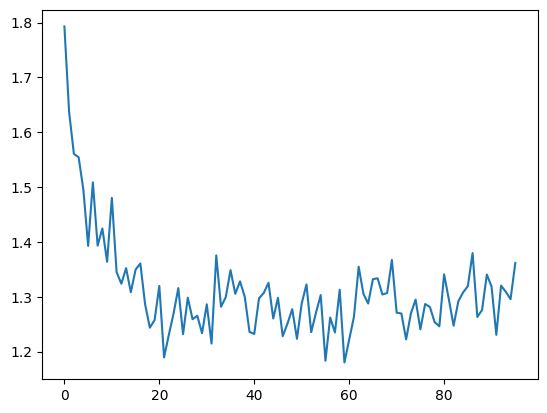

In [ ]:
df = pd.DataFrame({'val_loss': [np.mean(x) for x in val_loss], 'train_loss': [np.mean(x) for x in train_loss]})
df.plot(kind='line')

In [ ]:
with torch.no_grad():
    test_data = test_model(model, testLoader, device, dataSet.classes)
torch.cuda.empty_cache() if device == 'cuda' else None

In [ ]:
overall_accuracy = test_data[1].item()/test_data[2]
print(f'overall acc = {round(overall_accuracy*100,2)}%')

overall acc = 42.65%


<Axes: >

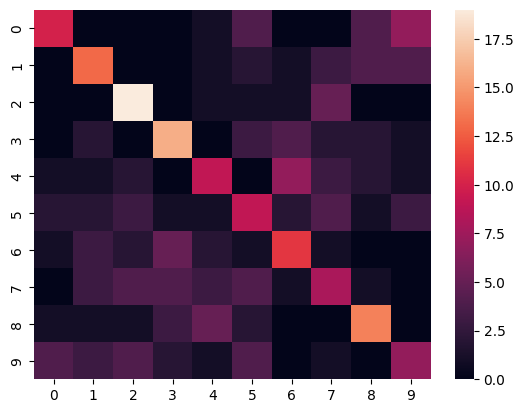

In [ ]:
from seaborn import heatmap
heatmap(test_data[0])

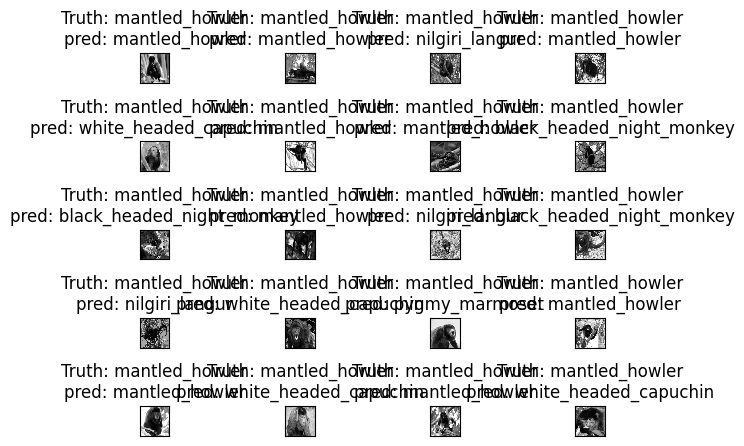

In [ ]:
print_images(model, testLoader, device, dataSet.classes)

C:\Users\user\AppData\Local\Temp\ipykernel_26280\3599481032.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


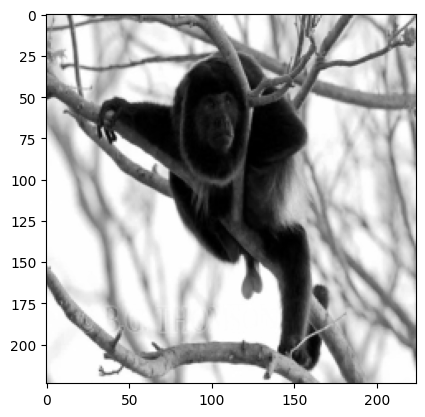

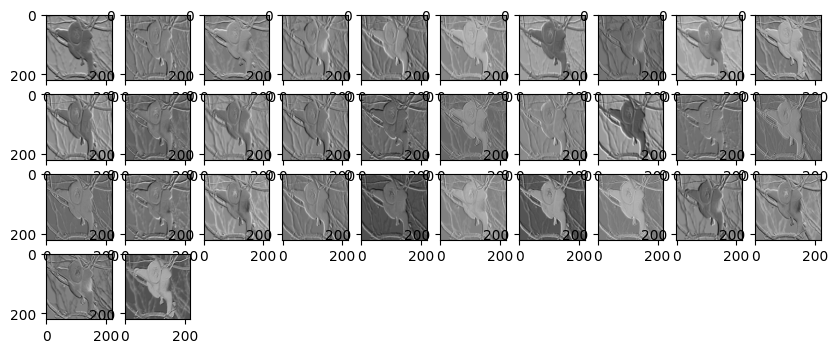

In [ ]:
visual_1st_layer(model, testLoader, device, img_n=5)

In [ ]:
torch.save(model.state_dict(), r'C:\Users\user\Desktop\dz\DL\lab4\results\model3_1.pth')
torch.save(optimizer.state_dict(), r'C:\Users\user\Desktop\dz\DL\lab4\results\optimizer3_1.pth')

### 3.2 Решить задачу классификации собак и кошек (датасет [cats_dogs.zip](https://disk.yandex.ru/d/wQtt5O1JF9ctnA)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью.

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 80%

In [ ]:
BATCH_SIZE = 150
INIT_LR = 1e-3
EPOCH = 350
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache() if device == 'cuda' else None

#### data prep

In [ ]:
transforms_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize([224, 224]),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20),
    torchvision.transforms.RandomPerspective(distortion_scale=0.3, p=1.0),
    torchvision.transforms.ElasticTransform(),
    torchvision.transforms.RandomAdjustSharpness(sharpness_factor=3),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])
transforms_val = torchvision.transforms.Compose([
    torchvision.transforms.Resize([224, 224]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

transforms_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize([224, 224]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [ ]:
trainPath = r'C:\Users\user\Desktop\dz\DL\lab4\data\cats_dogs\train'
dataSet = torchvision.datasets.ImageFolder(root = trainPath)

In [ ]:
trainSize = int(0.8*len(dataSet))
testSize = int(0.1*len(dataSet))
valSize = len(dataSet) - trainSize - testSize
trainDataSet, testDataSet, valDataSet = torch.utils.data.random_split(dataSet, [trainSize, testSize, valSize])

In [ ]:
trainDataSet.dataset.transform = transforms_train
testDataSet.dataset.transform = transforms_test
valDataSet.dataset.transform = transforms_val

In [ ]:
trainLoader = torch.utils.data.DataLoader(trainDataSet, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
valLoader = torch.utils.data.DataLoader(valDataSet, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
testLoader = torch.utils.data.DataLoader(testDataSet, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers = 0)

#### model


In [ ]:
class Model(nn.Module):
    def __init__(self, numClasses, imgShape):
        from functools import reduce
        super(Model, self).__init__()
        def find_new_shape(imgShape, kernel_sizes, stride_sizes, padding_sizes, dilation_sizes, ch_out=None):
            if ch_out:
                imgShape[0] = ch_out
            imgShape[1] = int(((imgShape[1] + 2*padding_sizes[0] - dilation_sizes[0]*(kernel_sizes[0]-1) - 1)/stride_sizes[0])+1)
            imgShape[2] = int(((imgShape[2] + 2*padding_sizes[1] - dilation_sizes[1]*(kernel_sizes[1]-1) - 1)/stride_sizes[1])+1)
            return imgShape
        imgShape = list(imgShape)
        # imgShape [ch, h, w]

        self.conv1 = nn.Conv2d(in_channels=imgShape[0], out_channels=32, kernel_size=(5, 5), stride=(1, 1), padding=(0, 0), dilation=(1,1))
        imgShape = find_new_shape(imgShape, (5, 5), (1, 1), (0, 0), (1, 1), 32)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=(1,1))
        self.drop1 = nn.Dropout2d(0.25)
        imgShape = find_new_shape(imgShape, (2, 2), (2, 2), (0, 0), (1, 1))

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), dilation=(1,1))
        imgShape = find_new_shape(imgShape, (3, 3), (1, 1), (0, 0), (1, 1), 64)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=(1,1))
        self.drop2 = nn.Dropout2d(0.25)
        imgShape = find_new_shape(imgShape, (2, 2), (2, 2), (0, 0), (1, 1))


        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), dilation=(1,1))
        imgShape = find_new_shape(imgShape, (3, 3), (1, 1), (0, 0), (1, 1), 128)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=(1,1))
        self.drop3 = nn.Dropout2d(0.25)
        imgShape = find_new_shape(imgShape, (2, 2), (2, 2), (0, 0), (1, 1))

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), dilation=(1,1))
        imgShape = find_new_shape(imgShape, (3, 3), (1, 1), (0, 0), (1, 1), 256)
        self.conv4_bn = nn.BatchNorm2d(256)
        self.maxpool4 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=(1,1))
        self.drop4 = nn.Dropout2d(0.25)
        imgShape = find_new_shape(imgShape, (2, 2), (2, 2), (0, 0), (1, 1))


        n_features = reduce(lambda x,y: x*y, imgShape)
        #hid 1
        self.fc1 = nn.Linear(in_features=n_features, out_features=512)
        self.lin_bn1 = nn.BatchNorm1d(512)
        self.relu1 = nn.ReLU()
        self.drop6 = nn.Dropout(0.5)
        #final
        self.fc4 = nn.Linear(in_features=512, out_features=numClasses)
        self.lin_bn4 = nn.BatchNorm1d(numClasses)
        self.logSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.drop1(self.maxpool1(self.conv1_bn(self.conv1(x))))

        x = self.drop2(self.maxpool2(self.conv2_bn(self.conv2(x))))

        x = self.drop3(self.maxpool3(self.conv3_bn(self.conv3(x))))

        x = self.drop4(self.maxpool4(self.conv4_bn(self.conv4(x))))

        x = torch.flatten(x, 1)

        x = self.drop6(self.relu1(self.lin_bn1(self.fc1(x))))

        x = self.lin_bn4(self.fc4(x))
        out = self.logSoftmax(x)

        return out

    def forward1l(self, x):
        x =  self.conv1_bn(self.conv1(x))
        return x

#### train and stuff

In [ ]:
imgShape = dataSet[0][0].size()
model = Model(len(dataSet.classes), imgShape).to(device)
print(f'кол-во параметров в модели = {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

кол-во параметров в модели = 19267846


In [ ]:
next(model.parameters()).is_cuda

True

In [ ]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=INIT_LR,
)
early_stopping = EarlyStopping(min_delta=0.1, tolerance=30)

In [ ]:
train_loss = []
val_loss = []
for epoch in tqdm(range(EPOCH)):
  epoch_train_loss = train_one_epoch(model, trainLoader, criterion, optimizer, device)
  train_loss.append(epoch_train_loss)

  with torch.no_grad():
    epoch_val_loss = val_one_epoch(model, valLoader, criterion, device)
    val_loss.append(epoch_val_loss)

  early_stopping(epoch_val_loss)
  if early_stopping.flag:
    print(f'\nearly stop at epoch №{epoch}')
    break

torch.cuda.empty_cache() if device == 'cuda' else None


 14%|███████████▎                                                                   | 50/350 [49:37<4:58:56, 59.79s/it]


early stop at epoch №50


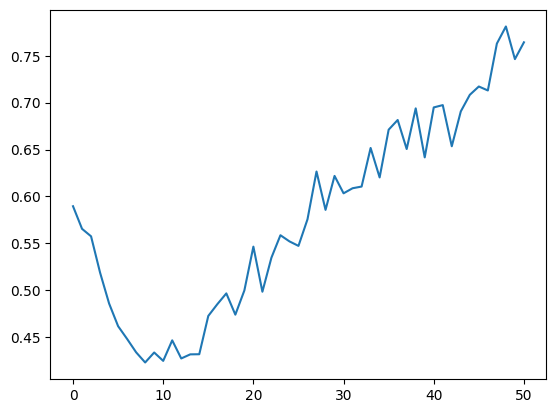

In [ ]:
df = pd.DataFrame({'val_loss': [np.mean(x) for x in val_loss], 'train_loss': [np.mean(x) for x in train_loss]})
df.plot(kind='line')

In [ ]:
with torch.no_grad():
    test_data = test_model(model, testLoader, device, dataSet.classes)
torch.cuda.empty_cache() if device == 'cuda' else None

In [ ]:
overall_accuracy = test_data[1].item()/test_data[2]
print(f'overall acc = {round(overall_accuracy*100,2)}%')

overall acc = 80.24%


<Axes: >

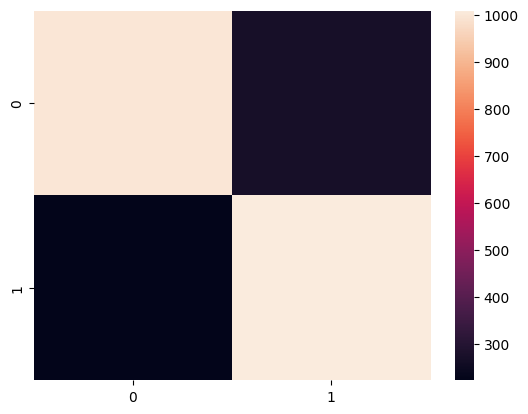

In [ ]:
from seaborn import heatmap
heatmap(test_data[0])

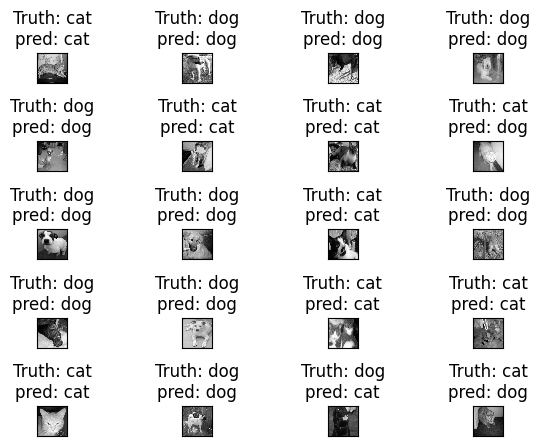

In [ ]:
print_images(model, testLoader, device, dataSet.classes)

C:\Users\user\AppData\Local\Temp\ipykernel_26280\3599481032.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


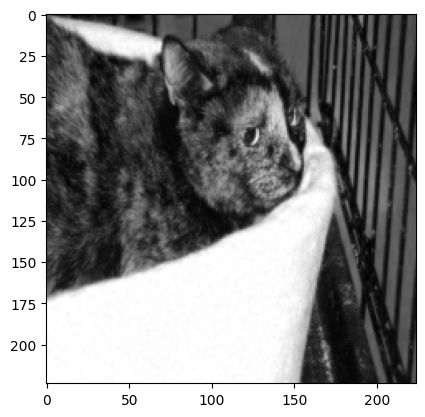

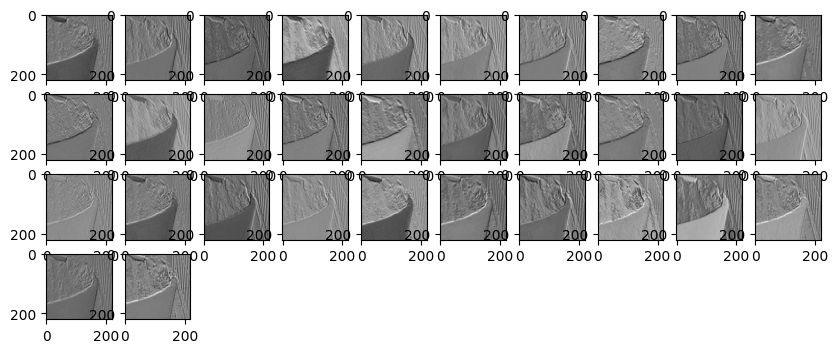

In [ ]:
visual_1st_layer(model, testLoader, device, img_n=23)

In [ ]:
torch.save(model.state_dict(), r'C:\Users\user\Desktop\dz\DL\lab4\results\model3_2.pth')
torch.save(optimizer.state_dict(), r'C:\Users\user\Desktop\dz\DL\lab4\results\optimizer3_2.pth')

# 4. Transfer Learning

### 4.1 Решить задачу 3.1, воспользовавшись предобученной моделью VGG16
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель (не замораживать веса). Вычислить значение accuracy на тестовом множестве
* Дообучить модель (заморозить все веса, кроме последнего блока слоев (`classifier`)).
* Вычислить значение accuracy на тестовом множестве.


In [ ]:
BATCH_SIZE = 128
INIT_LR = 1e-3
EPOCH = 150
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache() if device == 'cuda' else None

#### data prep

In [ ]:
transforms_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize([224, 224]),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20),
    torchvision.transforms.RandomPerspective(distortion_scale=0.3, p=1.0),
    torchvision.transforms.ElasticTransform(),
    torchvision.transforms.RandomAdjustSharpness(sharpness_factor=3),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])
transforms_val = torchvision.transforms.Compose([
    torchvision.transforms.Resize([224, 224]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

transforms_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize([224, 224]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [ ]:
trainPath = r'C:\Users\user\Desktop\dz\DL\lab4\data\monkeys\training\training'
testPath = r'C:\Users\user\Desktop\dz\DL\lab4\data\monkeys\validation\validation'
labelPath = r'C:\Users\user\Desktop\dz\DL\lab4\data\monkeys\monkey_labels.txt'
dataSet = torchvision.datasets.ImageFolder(root = trainPath)
testDataSet = torchvision.datasets.ImageFolder(root = testPath, transform=transforms_test)

In [ ]:
dataSet.classes, dataSet.class_to_idx = get_class_names(labelPath)
testDataSet.classes, testDataSet.class_to_idx = get_class_names(labelPath)

In [ ]:
trainSize = int(0.9*len(dataSet))
valSize = len(dataSet) - trainSize
trainDataSet, valDataSet = torch.utils.data.random_split(dataSet, [trainSize, valSize])
trainDataSet.dataset.transform = transforms_train
valDataSet.dataset.transform = transforms_val

In [ ]:
trainLoader = torch.utils.data.DataLoader(trainDataSet, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
valLoader = torch.utils.data.DataLoader(valDataSet, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
testLoader = torch.utils.data.DataLoader(testDataSet, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers = 0)

#### model


In [ ]:
model = torchvision.models.vgg16(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\user/.cache\torch\hub\checkpoints\vgg16-397923af.pth


  0%|                                                                                       | 0.00/528M [00:00<?, ?B/s]

  0%|                                                                               | 704k/528M [00:00<01:16, 7.19MB/s]

  0%|▏                                                                             | 1.46M/528M [00:00<01:14, 7.43MB/s]

  1%|▍                                                                             | 2.83M/528M [00:00<01:03, 8.69MB/s]

  1%|▌                                                                             | 3.95M/528M [00:00<00:58, 9.41MB/s]

  1%|▋                                                                             | 5.01M/528M [00:00<00:55, 9.84MB/s]

  1%|▉                                                                             | 5.99M/528M [00:00<00:57, 9.45MB/s]

  1%|█          

In [ ]:
model.parameters

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size

In [ ]:
model.classifier[6] = nn.Linear(in_features=4096, out_features=len(dataSet.classes))

#### train and stuff

In [ ]:
model.to(device)
print(f'кол-во параметров в модели = {sum(p.numel() for p in model.parameters() if p.requires_grad)}')
early_stopping = EarlyStopping()

кол-во параметров в модели = 134301514


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(
    model.parameters(),
    lr=INIT_LR,
)

##### Дообучение и тест модели без заморозки весов

In [ ]:
train_loss = []
val_loss = []
for epoch in tqdm(range(EPOCH)):
  epoch_train_loss = train_one_epoch(model, trainLoader, criterion, optimizer, device)
  train_loss.append(epoch_train_loss)

  with torch.no_grad():
    epoch_val_loss = val_one_epoch(model, valLoader, criterion, device)
    val_loss.append(epoch_val_loss)

  early_stopping(epoch_val_loss)
  if early_stopping.flag:
    print(f'\nearly stop at epoch №{epoch}')
    break

torch.cuda.empty_cache() if device == 'cuda' else None



  0%|                                                                                          | 0/150 [00:00<?, ?it/s]

  1%|▌                                                                               | 1/150 [00:55<2:18:45, 55.87s/it]

  1%|█                                                                               | 2/150 [01:44<2:12:18, 53.64s/it]

  2%|█▌                                                                              | 3/150 [02:32<2:07:32, 52.05s/it]

  3%|██▏                                                                             | 4/150 [03:20<2:03:45, 50.86s/it]

  3%|██▋                                                                             | 5/150 [04:09<2:01:09, 50.14s/it]

  4%|███▏                                                                            | 6/150 [04:57<1:58:56, 49.56s/it]

  5%|███▋                                                                            | 7/150 [05:45<1:57:19, 49.23s/it]

  5%|████▎                    


early stop at epoch №31


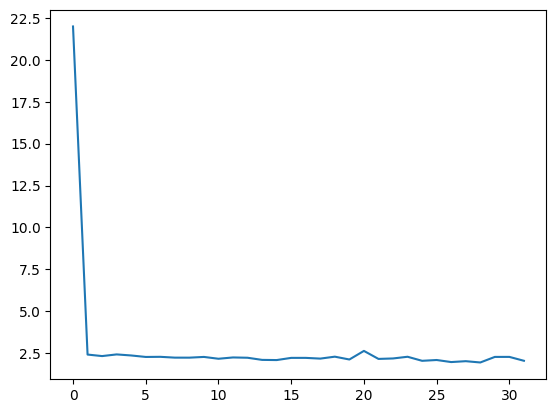

In [ ]:
df = pd.DataFrame({'val_loss': [np.mean(x) for x in val_loss], 'train_loss': [np.mean(x) for x in train_loss]})
df.plot(kind='line')

In [ ]:
with torch.no_grad():
    test_data = test_model(model, testLoader, device, dataSet.classes)
torch.cuda.empty_cache() if device == 'cuda' else None

In [ ]:
overall_accuracy = test_data[1].item()/test_data[2]
print(f'overall acc = {round(overall_accuracy*100,2)}%')

overall acc = 35.66%


<Axes: >

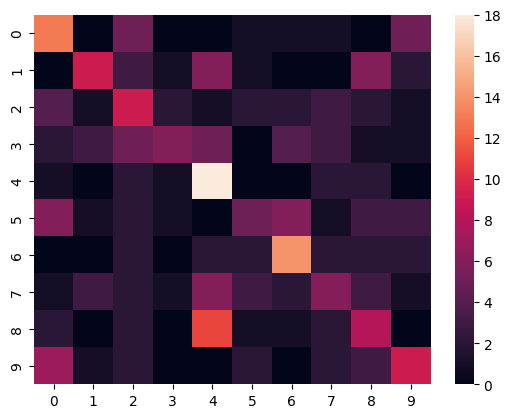

In [ ]:
from seaborn import heatmap
heatmap(test_data[0])

##### Продолжение дообучения с заморозкой всех весов, кроме слоя Classifier

In [ ]:
for param in model.features:
    param.requires_grad = False

In [ ]:
train_loss = []
val_loss = []
for epoch in tqdm(range(EPOCH)):
  epoch_train_loss = train_one_epoch(model, trainLoader, criterion, optimizer, device)
  train_loss.append(epoch_train_loss)

  with torch.no_grad():
    epoch_val_loss = val_one_epoch(model, valLoader, criterion, device)
    val_loss.append(epoch_val_loss)

  early_stopping(epoch_val_loss)
  if early_stopping.flag:
    print(f'\nearly stop at epoch №{epoch}')
    break

torch.cuda.empty_cache() if device == 'cuda' else None




  0%|                                                                                          | 0/150 [00:00<?, ?it/s]


early stop at epoch №0


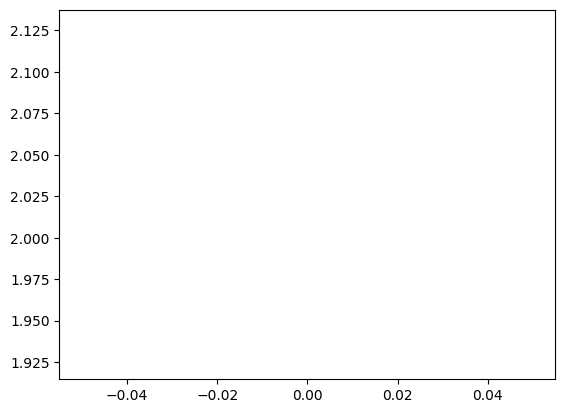

In [ ]:
df = pd.DataFrame({'val_loss': [np.mean(x) for x in val_loss], 'train_loss': [np.mean(x) for x in train_loss]})
df.plot(kind='line')

In [ ]:
with torch.no_grad():
    test_data = test_model(model, testLoader, device, dataSet.classes)
torch.cuda.empty_cache() if device == 'cuda' else None

In [ ]:
overall_accuracy = test_data[1].item()/test_data[2]
print(f'overall acc = {round(overall_accuracy*100,2)}%')

overall acc = 37.87%


<Axes: >

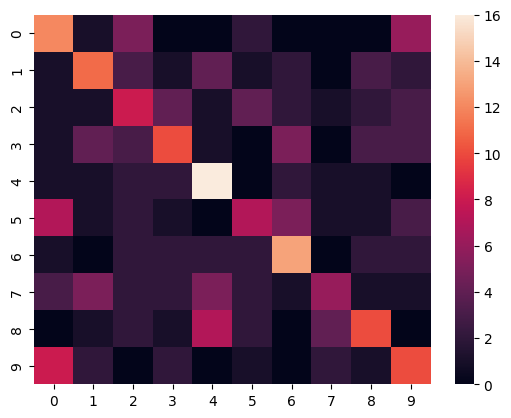

In [ ]:
from seaborn import heatmap
heatmap(test_data[0])

### 4.2 Решить задачу 3.2, воспользовавшись подходящей предобученной моделью
* Не использовать VGG16 (вместо нее можно взять resnet18 или другую)
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель.
* Вычислить значение accuracy на тестовом множестве (добиться значения не меньше 97-98%)

In [ ]:
BATCH_SIZE = 128
INIT_LR = 1e-3
EPOCH = 150
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache() if device == 'cuda' else None

#### data prep

In [ ]:
transforms_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize([224, 224]),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20),
    torchvision.transforms.RandomPerspective(distortion_scale=0.3, p=1.0),
    torchvision.transforms.ElasticTransform(),
    torchvision.transforms.RandomAdjustSharpness(sharpness_factor=3),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])
transforms_val = torchvision.transforms.Compose([
    torchvision.transforms.Resize([224, 224]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

transforms_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize([224, 224]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [ ]:
trainPath = r'C:\Users\user\Desktop\dz\DL\lab4\data\cats_dogs\train'
dataSet = torchvision.datasets.ImageFolder(root = trainPath)

In [ ]:
trainSize = int(0.8*len(dataSet))
testSize = int(0.1*len(dataSet))
valSize = len(dataSet) - trainSize - testSize
trainDataSet, testDataSet, valDataSet = torch.utils.data.random_split(dataSet, [trainSize, testSize, valSize])

In [ ]:
trainDataSet.dataset.transform = transforms_train
testDataSet.dataset.transform = transforms_test
valDataSet.dataset.transform = transforms_val

In [ ]:
trainLoader = torch.utils.data.DataLoader(trainDataSet, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
valLoader = torch.utils.data.DataLoader(valDataSet, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 0)
testLoader = torch.utils.data.DataLoader(testDataSet, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers = 0)

#### model


In [ ]:
model = torchvision.models.resnet18(weights='IMAGENET1K_V1', progress=False)
print(f'кол-во параметров в модели = {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

кол-во параметров в модели = 11689512


In [ ]:
model.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [ ]:
model.fc = nn.Sequential(nn.Linear(in_features=512, out_features=len(dataSet.classes)), nn.Sigmoid())

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### train and stuff

In [ ]:
model.to(device)
print(f'кол-во параметров в модели = {sum(p.numel() for p in model.parameters() if p.requires_grad)}')
early_stopping = EarlyStopping()

кол-во параметров в модели = 11177538


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(
    model.parameters(),
    lr=INIT_LR,
)

In [ ]:
train_loss = []
val_loss = []
for epoch in tqdm(range(EPOCH)):
  epoch_train_loss = train_one_epoch(model, trainLoader, criterion, optimizer, device)
  train_loss.append(epoch_train_loss)

  with torch.no_grad():
    epoch_val_loss = val_one_epoch(model, valLoader, criterion, device)
    val_loss.append(epoch_val_loss)

  early_stopping(epoch_val_loss)
  if early_stopping.flag:
    print(f'\nearly stop at epoch №{epoch}')
    break

torch.cuda.empty_cache() if device == 'cuda' else None





  0%|                                                                                          | 0/150 [00:00<?, ?it/s]



  1%|▌                                                                               | 1/150 [00:58<2:24:26, 58.17s/it]



  1%|█                                                                               | 2/150 [01:56<2:23:25, 58.14s/it]



  2%|█▌                                                                              | 3/150 [02:54<2:22:16, 58.07s/it]



  3%|██▏                                                                             | 4/150 [03:52<2:21:28, 58.14s/it]



  3%|██▋                                                                             | 5/150 [04:50<2:20:31, 58.15s/it]



  4%|███▏                                                                            | 6/150 [05:49<2:19:55, 58.30s/it]



  5%|███▋                                                                            | 7/150 [06:47<2:18:55, 58.29s/it]



  5%|████▎  

In [ ]:
df = pd.DataFrame({'val_loss': [np.mean(x) for x in val_loss], 'train_loss': [np.mean(x) for x in train_loss]})
df.plot(kind='line')

In [ ]:
with torch.no_grad():
    test_data = test_model(model, testLoader, device, dataSet.classes)
torch.cuda.empty_cache() if device == 'cuda' else None

In [ ]:
overall_accuracy = test_data[1].item()/test_data[2]
print(f'overall acc = {round(overall_accuracy*100,2)}%')

In [ ]:
from seaborn import heatmap
heatmap(test_data[0])